# Measuring particularity and similarity in archaic Greek alphabets with NLP


In [1]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import heatmap, annotate_heatmap, get_top_abs_correlations

Uncomment and run the following cells if you would like to see all rows/columns in the dataframes.

In [2]:
# pd.set_option("display.max_rows", None)

In [3]:
# pd.set_option("display.max_columns", None)

Load the TF-IDF vectorizer setting a space as the boundary between tokens.

In [4]:
vectorizer = TfidfVectorizer(token_pattern=r'\S+')

## Sanity check example

A simple example to test TF-IDF and cosine similarity on three sample sentences.

In [5]:
ex_docs = ['The Cretan alphabet is a green alphabet', 'The Euboean alphabet is red', 'Cretan is a Greek dialect']

We parse the sentences with the TF-IDF vectorizer and show the results in a dataframe.

In [6]:
ex_matrix = vectorizer.fit_transform(ex_docs)

In [7]:
docs_df = pd.DataFrame(ex_matrix.toarray(),columns=vectorizer.get_feature_names())
docs_df

,a,alphabet,cretan,dialect,euboean,greek,green,is,red,the
0,0.327350,0.654700,0.327350,0.000000,0.000000,0.000000,0.430426,0.254217,0.000000,0.327350
1,0.000000,0.406192,0.000000,0.000000,0.534093,0.000000,0.000000,0.315444,0.534093,0.406192
2,0.406192,0.000000,0.406192,0.534093,0.000000,0.534093,0.000000,0.315444,0.000000,0.000000


We calculate the cosine similarity of each pair of sentences and put the results in a dataframe.

In [8]:
ex_similarity = cosine_similarity(ex_matrix, ex_matrix)
ex_similarity

array([[1.        , 0.47909206, 0.34612509],
       [0.47909206, 1.        , 0.09950501],
       [0.34612509, 0.09950501, 1.        ]])

In [9]:
sent_comp_df = pd.DataFrame(ex_similarity,columns=ex_docs, index=ex_docs)
sent_comp_df

,The Cretan alphabet is a green alphabet,The Euboean alphabet is red,Cretan is a Greek dialect
The Cretan alphabet is a green alphabet,1.000000,0.479092,0.346125
The Euboean alphabet is red,0.479092,1.000000,0.099505
Cretan is a Greek dialect,0.346125,0.099505,1.000000


## Data pre-processing

We load the dataset, which in this case consists on a record of all Greek alphabetic inscriptions from the 8th and 7th centuries BC.

In [10]:
with open('data/dataset.json') as f:
  data = json.load(f)

The total number of inscriptions in the dataset:

In [11]:
len(data)

714

The fields in each inscription: 

In [12]:
data[0].keys()

dict_keys(['Reference', 'Date', 'Origin', 'Lat', 'Long', 'Context', 'Material: object', 'Writing method', 'Writing direction', 'Content', 'a/a:', 'e', 'i/i:', 'o', 'u/u:/y/y:', '3:', '0:', 'e:', 'o:', 'm', 'n', 'l', 'r', 'w', 'h', 's', 'b', 'd', 'g', 'p', 't', 'k', 'ko/ku', 'ph', 'th', 'kh', 'ps', 'ks', 'dz', 'Division', 'Uncertain'])

We create a dictionary (documents) where each key represents an archaeological site or region and each value is a list with all grapheme-phoneme pairs recorded in the dataset for that site or region. This will be parsed with the TF-IDF vectoriser.

At the same time we produce another dictionary (alphabets) where each key represents an archaeological site or region and each value is a nested dictionary where the keys are all phonemes and the values are lists of graphemes used to represent that phoneme. This will be used to reconstruct specific alphabets later.
 

In [13]:
def build_documents(data):
  # build a dictionary with all documents to parse through the vectoriser
  # {origin: [list of grapheme-phoneme tokens]}
  documents = defaultdict(list)
  
  # build a dictionary with all grapheme-phoneme pairs seen for each place of origin
  # {origin: {phoneme: [list of graphemes]}}
  alphabets = {}
  
  checking_keys = ['a/a:', 'e', 'i/i:', 'o', 'u/u:/y/y:', '3:', '0:', 'e:', 'o:', 'm', 'n', 'l', 'r', 'w', 'h', 's', 'b', 'd', 'g', 'p', 't', 'k', 'ko/ku', 'ph', 'th', 'kh', 'ps', 'ks', 'dz', 'Division']

  # in each inscription, add each grapheme-phoneme pair to origin
  for inscription in data:
    origin = inscription['Origin']
   
    if '?' not in origin: #exclude uncertain

      # add origin to alphabets dict
      if origin not in alphabets.keys():
        alphabets[origin] = {key: [] for key in checking_keys}

      # add values to documents and alphabets dict
      for key, values in inscription.items():
        if key in checking_keys:
          for value in values:
            if '?' not in value: #exclude uncertain
              token = key+value
              documents[origin].append(token)
              alphabets[origin][key].append(value)

    else:
      continue
  
  # we turn the lists into strings, filter empty values and put in alphabetical order
  documents = {k: ' '.join(v) for k, v in documents.items() if v}

  for alphabet in alphabets.keys():
    for k,v in alphabets[alphabet].items():
          alphabets[alphabet][k] = ', '.join(list(set(v)))
  
  return documents,alphabets


In [14]:
documents,alphabets = build_documents(data)

We order the documents alphabetically and show them in a dataframe:

In [15]:
sorted_docs = sorted(documents.items())
documents_df = pd.DataFrame(sorted_docs, columns=['Origin', 'Text'])
documents_df

,Origin,Text
0,Achaia,a/a:1 e15 o43 m37 s38 d13 k33
1,Acrocorinth,a/a:1 e3 i/i:30* o43 0:43 e:15 n40 n40* l10 w1...
2,Aegina,e15 i/i:28 o43 n40 s32 p11 a/a:1 e15 m38 n40 l...
3,Aeolian Larisa,a/a:1 e15 e21 3:21 n40 d13 t57 a/a:1 e15 e21 3...
4,Aetos,a/a:1 e15 i/i:54 o43 n40 l34 w18 h23 s38 t57 p...
...,...,...
62,Thebes,a/a:1 e15 i/i:28 o43 u/u:/y/y:58 3:15 0:43 o:4...
63,Thera,i/i:31 0:43 n40 r52 kh33+23 a/a:1 e15 i/i:31 i...
64,Thermon,a/a:1 e15 i/i:31 o43 n40 l10 r52 w18 s38 d14 t...
65,Vari,a/a:1 e15 i/i:28 o:43 r52 d13 p47 kh41


Here is the relation of all graphematic relationships recorded for each site/region:

In [16]:
alphabets = {k:v for k,v in sorted(alphabets.items()) if v}
alphabets_df = pd.DataFrame(alphabets).T
alphabets_df

,a/a:,e,i/i:,o,u/u:/y/y:,3:,0:,e:,o:,m,...,t,k,ko/ku,ph,th,kh,ps,ks,dz,Division
Achaia,1,15,,43,,,,,,37,...,,33,,,,,,,,
Acrocorinth,1,3,30*,43,,,43,15,,,...,57,,,,,,,,,
Aegina,1,15,28,43,,15,,,,"38, 37",...,,33,,,,,,,,
Aeolian Larisa,1,"15, 21",28,43,,21,,,,,...,57,,,,,,,,,66
Aetos,1,15,"54, 32",43,,,,,,,...,57,33,,60,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thebes,1,15,28,43,58,15,43,,43,36,...,57,33,51,,25,,,,,
Thera,1,15,"32*, 30*, 30, 54*, 31, 55, 31*","44, 43",58,"15, 23","44, 43","15+31, 15",43,"36, 37",...,57,33,51,50+23,"27, 25, 25+23","51+23, 33+23",,33+38,42,68
Thermon,1,15,31,43,,,,,,,...,57,,,,,41,,,,
Vari,1,15,28,,,,,,43,,...,,,,,,41,,,,


Run this cell to save the output as an Excel file:

In [17]:
alphabets_df.to_excel('output/all_alphabets.xlsx')

## Particularity: TF-IDF 

We measure the relevance of grapheme-phoneme pairs for each site/region using TF-IDF.

We parse the documents with the TF-IDF vectorizer and display them in a matrix.

In [18]:
matrix = vectorizer.fit_transform(documents_df['Text'])

In [19]:
matrix_df = pd.DataFrame(matrix.toarray(),columns=vectorizer.get_feature_names())
matrix_df

,0:43,0:44,0:45,0:64,3:15,3:21,3:23,3:3,a/a:1,a/a:2,...,th25,th25+23,th26,th27,th44,u/u:/y/y:58,u/u:/y/y:59,w17,w18,w19
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.272952,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.233851,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.120926,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.197732,0.0
2,0.000000,0.000000,0.0,0.0,0.165502,0.000000,0.000000,0.0,0.250787,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.479388,0.000000,0.0,0.258422,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.243835,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.199352,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.143765,0.000000,0.0,0.0,0.294363,0.000000,0.000000,0.0,0.148684,0.0,...,0.229804,0.000000,0.0,0.000000,0.0,0.217758,0.0,0.0,0.243120,0.0
63,0.026837,0.243051,0.0,0.0,0.082424,0.000000,0.207377,0.0,0.194285,0.0,...,0.107244,0.053393,0.0,0.045217,0.0,0.182921,0.0,0.0,0.000000,0.0
64,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.185218,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.302857,0.0
65,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.217310,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


These are the 2 tokens with highest TF-IDF score per site/region:

In [20]:

values_df = pd.DataFrame(documents_df['Origin'])
values_df['1token'] = matrix_df.columns[matrix_df.values.argsort(1)[:, -1]]
values_df['1score'] = matrix_df.apply(lambda row: sorted(row)[-1], axis=1)
values_df['2token'] = matrix_df.columns[matrix_df.values.argsort(1)[:, -2]]
values_df['2score'] = matrix_df.apply(lambda row: sorted(row)[-2], axis=1)
values_df

,Origin,1token,1score,2token,2score
0,Achaia,d13,0.493829,s38,0.446314
1,Acrocorinth,s38*,0.465259,n40*,0.423581
2,Aegina,s32,0.400992,l10,0.387612
3,Aeolian Larisa,e21,0.662844,3:21,0.479388
4,Aetos,i/i:54,0.469071,s38,0.398704
...,...,...,...,...,...
62,Thebes,3:15,0.294363,d13,0.269002
63,Thera,i/i:31*,0.340676,kh33+23,0.266966
64,Thermon,i/i:31,0.494362,kh41,0.406258
65,Vari,p47,0.476651,kh41,0.476651


Run the following cell if you wish to save the the results as an excel file:

In [23]:
values_df.to_excel('output/most_characteristic_not_normalized.xlsx')

These results turned out not to be a good representation of the most idiosyncratic graphematic relationships per alphabet, as those sites with very low numbers of evidence gave higher scores to all of their features, irrespective of whether these are common across alphabets or not. That is what happens with Al Mina or Zagora.


Here is the number of tokens of Al Mina and Zagora as compared to other sites with high volumes of evidence, like Penteskouphia and Athens.

In [38]:
print(f"Al Mina: {len(documents['Al Mina'].split())}")
print(f"Zagora: {len(documents['Zagora'].split())}")

print(f"Penteskouphia: {len(documents['Penteskouphia'].split())}")
print(f"Athens: {len(documents['Athens'].split())}")

Al Mina: 3
Zagora: 5
Penteskouphia: 967
Athens: 197


### Normalising the results

To get more plausible results we normalise the results of TF-IDF using the L1 norm, which will neutralise the broad differences in the length of these documents.

In [24]:
l1_matrix = preprocessing.normalize(matrix, norm='l1',axis=0)

In [25]:
l1_matrix_df = pd.DataFrame(l1_matrix.toarray(),columns=vectorizer.get_feature_names())
l1_values_df = pd.DataFrame(documents_df['Origin'])

Here is a table with the 10 most representative graphematic relationships per site/region after L1 normalisation.

In [26]:
value = 0
while value > -10:
  value -= 1
  token = 'token'+str(value)
  score = 'score'+str(value)
  l1_values_df[token] = l1_matrix_df.columns[l1_matrix_df.values.argsort(1)[:, value]]
  l1_values_df[score] = l1_matrix_df.apply(lambda row: sorted(row)[value], axis=1)

l1_values_df

,Origin,token-1,score-1,token-2,score-2,token-3,score-3,token-4,score-4,token-5,...,token-6,score-6,token-7,score-7,token-8,score-8,token-9,score-9,token-10,score-10
0,Achaia,d13,0.124456,m37,0.083892,s38,0.061849,k33,0.059216,o43,...,e15,0.023033,a/a:1,0.021030,h22,0.000000,i/i:28,0.000000,h24,0.000000
1,Acrocorinth,s38*,1.000000,i/i:30*,0.648712,n40*,0.591263,e3,0.139095,e:15,...,0:43,0.087999,w18,0.047290,d14,0.035881,p49,0.032871,l10,0.030005
2,Aegina,p11,1.000000,n40*,0.408737,s32,0.146500,s31*,0.065675,l10,...,h23,0.051825,m38,0.051502,3:15,0.045303,k33,0.036272,e15,0.028217
3,Aeolian Larisa,e21,1.000000,3:21,0.366981,division66,0.359459,d13,0.039277,t57,...,p49,0.023415,e15,0.021807,a/a:1,0.019910,n40,0.018391,i/i:28,0.010372
4,Aetos,i/i:54,1.000000,i/i:32,0.114467,h23,0.075582,ph60,0.065411,s38,...,l34,0.052806,w18,0.047677,p49,0.033140,l10,0.030251,k33,0.026450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Thebes,h24,0.915558,p48,0.695381,s32*,0.245304,s55,0.184278,3:15,...,o:43,0.076040,d13,0.067795,s31*,0.058405,w18,0.058145,0:43,0.054099
63,Thera,kh33+23,1.000000,ph50+23,1.000000,b6,1.000000,i/i:55,1.000000,kh51+23,...,i/i:54*,1.000000,e:15+31,1.000000,th25+23,1.000000,i/i:32*,0.911107,dz42,0.836728
64,Thermon,i/i:31,0.220710,kh41,0.163194,w18,0.072432,d14,0.054958,l10,...,s38,0.041969,r52,0.028150,t57,0.027604,n40,0.019772,o43,0.017323
65,Vari,kh41,0.191470,p47,0.180192,o:43,0.111136,d13,0.099086,r52,...,i/i:28,0.026167,e15,0.018338,a/a:1,0.016743,g8,0.000000,g4,0.000000


Run the following cell if you wish to save the the results as an excel file:

In [27]:
l1_values_df.to_excel('output/most_characteristic_per_alph_l1.xlsx')

## Similarity: cosine similarity

Now we will calculate the cosine similarity of all pairs of alphabets using their non-normalised TF-IDF weights.

In [28]:
similarity = cosine_similarity(matrix, matrix)

In [31]:
similarity_df = pd.DataFrame(similarity, columns = documents_df['Origin'])
similarity_df.corr()

We can also plot the results in a heatmap:

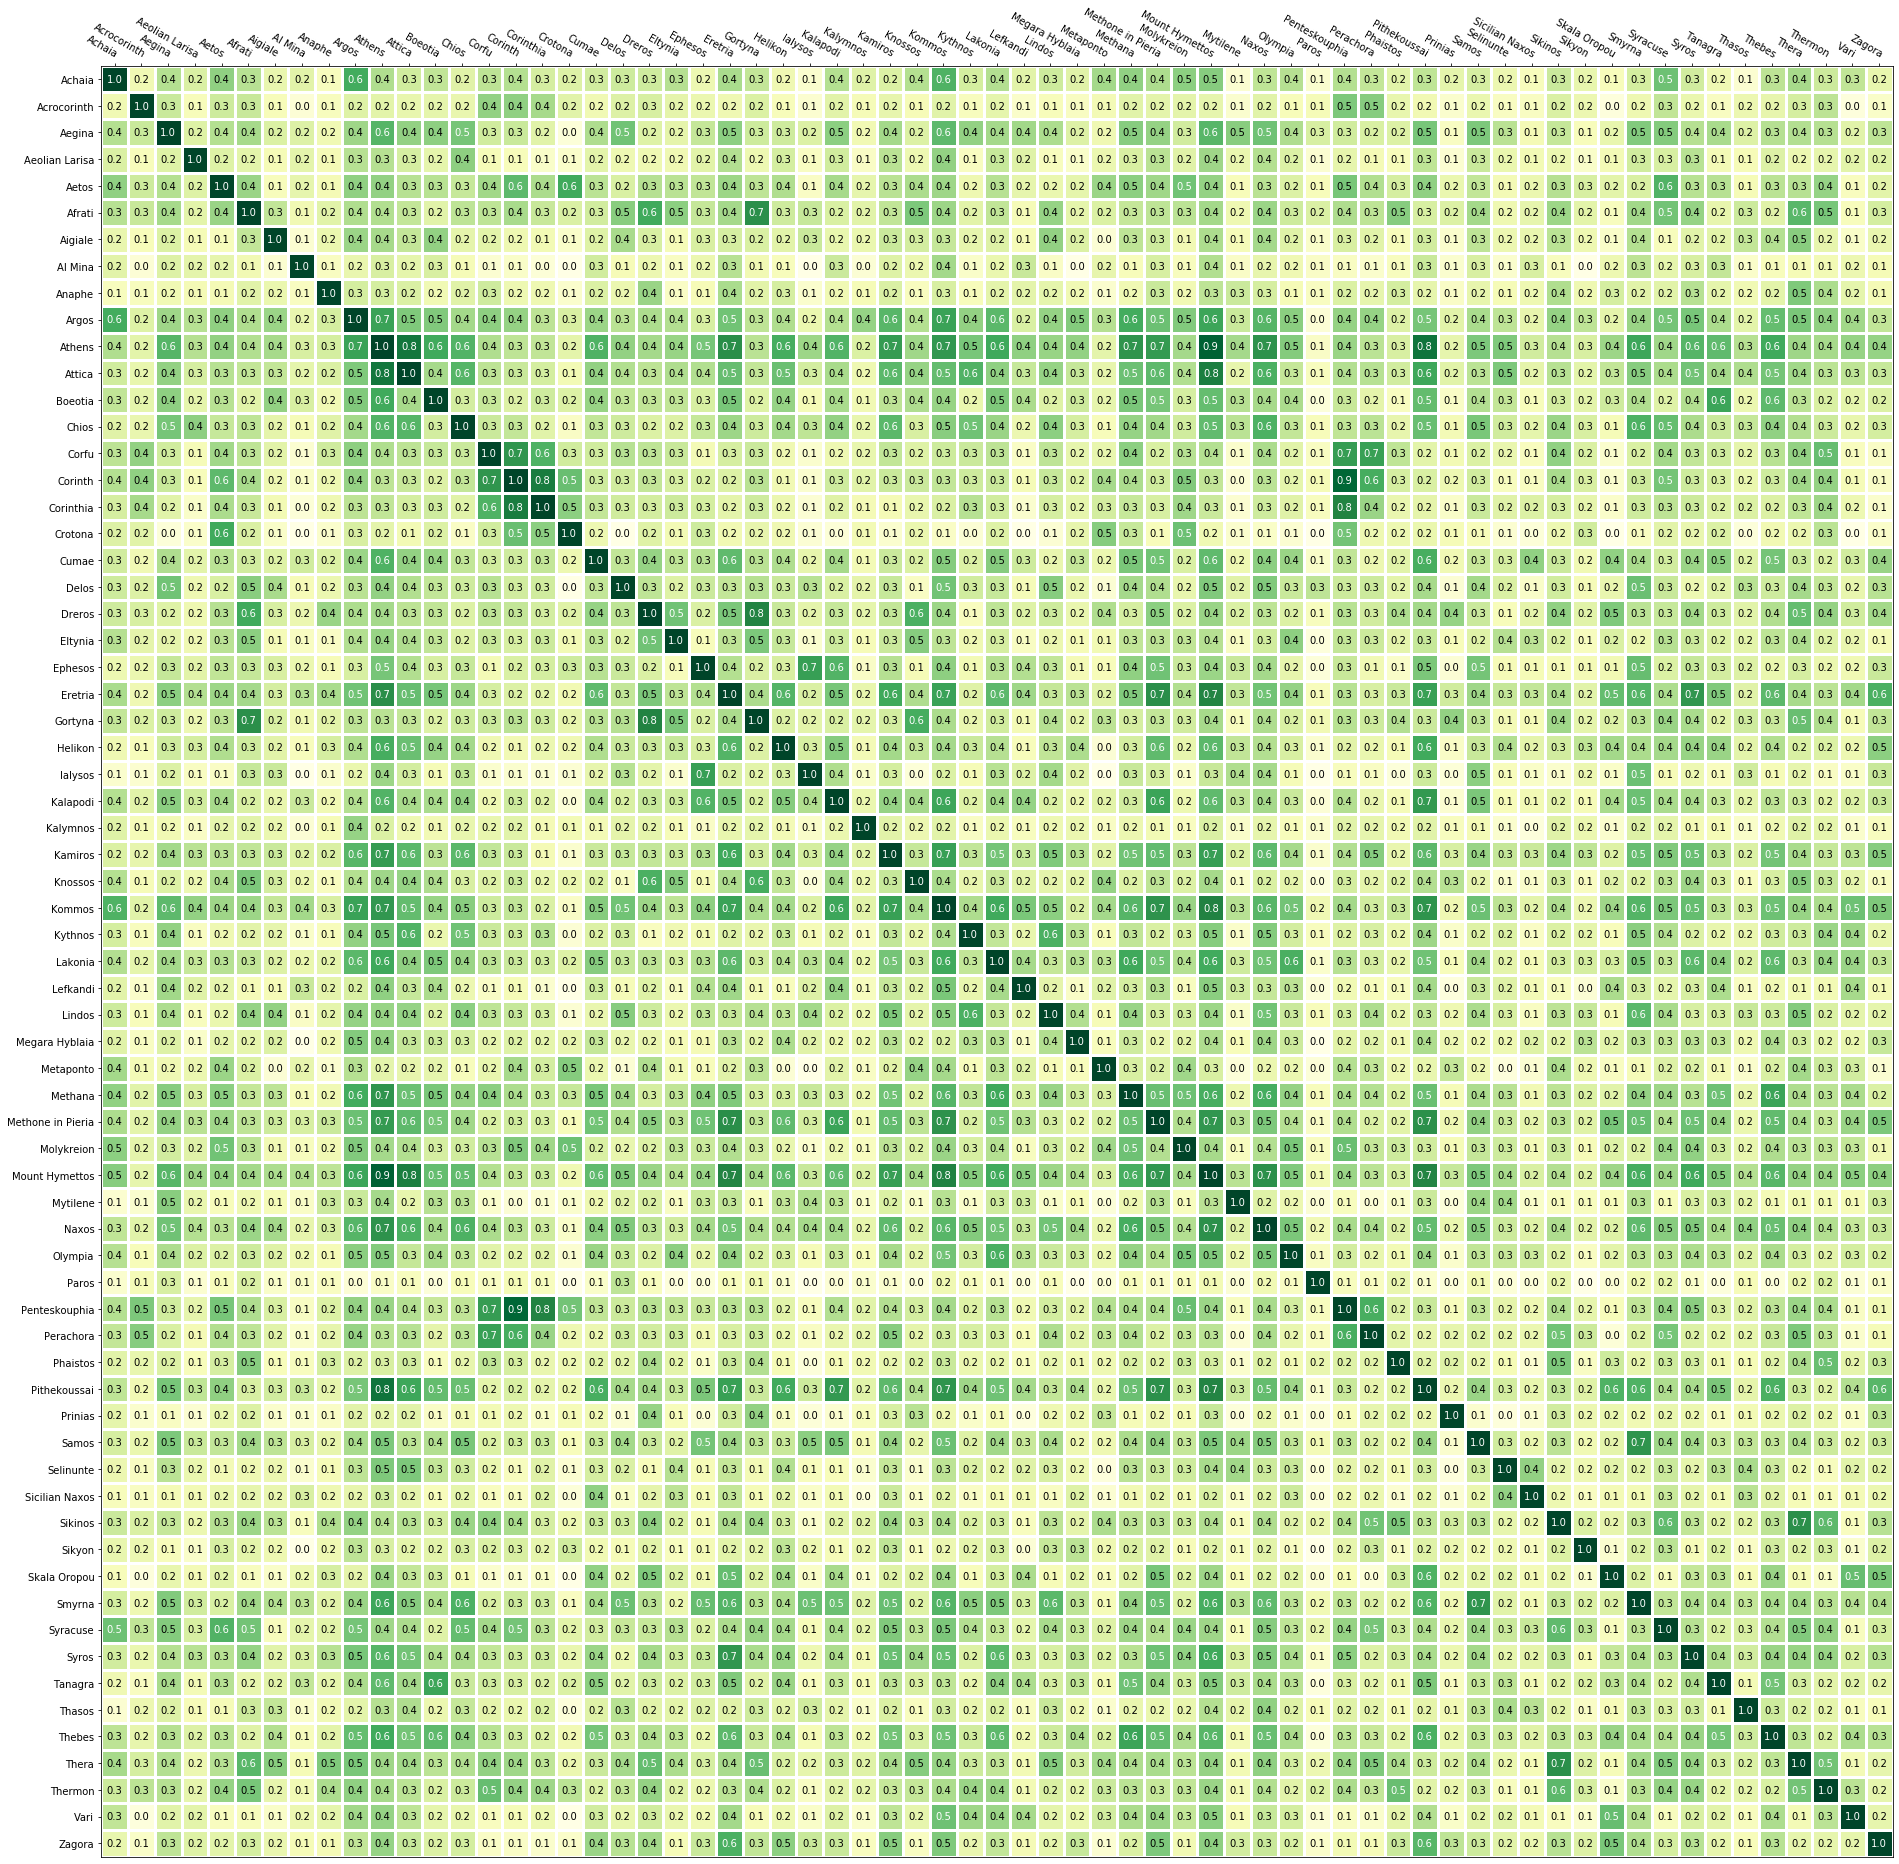

In [29]:
plt.rcParams['figure.figsize'] = [30, 26]
fig, ax = plt.subplots()

im = heatmap(similarity, documents_df['Origin'], documents_df['Origin'], ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

Run the following cell to save the heatmap as a .png image:

In [30]:
plt.savefig('output/heatmap.png')

<Figure size 2160x1872 with 0 Axes>

Now we can order the pairs with a score over 0.8 from higher to lower score.

In [33]:
top_pairs = get_top_abs_correlations(similarity_df, min_val=0.8)
top_pairs

Score
Origin            Origin                     
Athens            Mount Hymettos     0.959211
Corinth           Penteskouphia      0.954639
                  Corinthia          0.916038
Athens            Pithekoussai       0.907368
Corinthia         Penteskouphia      0.904290
Eretria           Methone in Pieria  0.900297
Methone in Pieria Pithekoussai       0.899898
Athens            Attica             0.899682
Mount Hymettos    Pithekoussai       0.883448
Attica            Mount Hymettos     0.882679
Kommos            Mount Hymettos     0.880218
Eretria           Mount Hymettos     0.875251
Corfu             Corinth            0.868908
Methone in Pieria Mount Hymettos     0.868275
Corfu             Perachora          0.863878
Dreros            Gortyna            0.862636
Boeotia           Tanagra            0.859695
Kommos            Methone in Pieria  0.857589
Afrati            Gortyna            0.857025
Athens            Methone in Pieria  0.851867
Eretria           Pithekoussai       0.851395
Corfu             Penteskouphia      0.848458
Samos             Smyrna             0.845496
Sikinos           Thera              0.844121
Mount Hymettos    Naxos              0.829397
Kamiros           Mount Hymettos     0.828178
Athens            Eretria            0.825564
                  Naxos              0.825111
Kalapodi          Methone in Pieria  0.823811
                  Pithekoussai       0.819014
Ephesos           Ialysos            0.812743
Eretria           Syros              0.809036
Athens            Kamiros            0.806187
Corfu             Corinthia          0.805570
Methana           Thebes             0.805279
Kommos            Pithekoussai       0.805268
Athens            Kommos             0.803354
                  Lakonia            0.800992
Eretria           Kommos             0.800208

Run the following cell to save the dataframe as an Excel file:

In [34]:
top_pairs.to_excel('output/top_alph_pairs.xlsx')